In [28]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## Behavorial Cloning  

### Review Articles
- [An overview of gradient descent optimization algorithms](http://ruder.io/optimizing-gradient-descent/index.html#adam)

### Enrichment Readings 
- [Review: SegNet (Semantic Segmentation)](https://towardsdatascience.com/review-segnet-semantic-segmentation-e66f2e30fb96)
- [Installing TensorFlow Object Detection API on Windows 10](https://medium.com/@marklabinski/installing-tensorflow-object-detection-api-on-windows-10-7a4eb83e1e7b)
- [Multi-Sensor Data Fusion (MSDF) for Driverless Cars, An Essential Primer
](https://medium.com/@lance.eliot/multi-sensor-data-fusion-msdf-for-driverless-cars-an-essential-primer-a1948bb8b57c)
- [How to validate your deep learning model with the Diffgram SDK — Tutorial](https://medium.com/diffgram/how-to-validate-your-deep-learning-model-with-the-diffgram-sdk-tutorial-22234a9a35?_hsenc=p2ANqtz-_o0BTtZu_UHjEOD4taLJqxrDs0xDP_xl-Do12O-pIoMFjzmoS945j4gYYqt96YCTANNiUtfOuRCPnutqNDwwtgSCRMhQ&_hsmi=74444548)
- [How do I design a visual deep learning system in 2019?](https://medium.com/diffgram/how-do-i-design-a-visual-deep-learning-system-in-2019-8597aaa35d03?_hsenc=p2ANqtz-_o0BTtZu_UHjEOD4taLJqxrDs0xDP_xl-Do12O-pIoMFjzmoS945j4gYYqt96YCTANNiUtfOuRCPnutqNDwwtgSCRMhQ&_hsmi=74444548)

### Useful Tips
- [A detailed example of how to use data generators with Keras](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)
- [Writing Custom Keras Generators](https://towardsdatascience.com/writing-custom-keras-generators-fe815d992c5a)

### Image Database
- [A dataset of images containing...](https://www.kaggle.com/moltean/fruits/downloads/fruits.zip/57)

### General Tips
- It is not necessary to use the left and right images to derive a successful model. Recording recovery driving from the sides of the road is also effective.

**Center Driving**

So that the car drives down the center of the road, it's essential to capture center lane driving. Try driving around the track various times while staying as close to the middle of the track as possible even when making turns.

In the real world, the car would need to stay in a lane rather than driving down the center. But for the purposes of this project, aim for center of the road driving.

**Strategies for Collecting Data**

Now that you have driven the simulator and know how to record data, it's time to think about collecting data that will ensure a successful model. There are a few general concepts to think about that we will later discuss in more detail:

- the car should stay in the center of the road as much as possible
- if the car veers off to the side, it should recover back to center
- driving counter-clockwise can help the model generalize
- flipping the images is a quick way to augment the data
- collecting data from the second track can also help generalize the model
- we want to avoid overfitting or underfitting when training the model
- knowing when to stop collecting more data


## Prerequisite Steps Prior to Training  

### Data Generation Algorithm  

### Data Augmentation and Pre-Processing  


## Training Models Using Data Provided  

At the first step, I used the images that are already provided for training. I used three different models for training and prediction. 

1. No transfer learning - Training A New CNN Model from Scratch  
- Full Transfer Learning: Training a CNN Model Based on Inception Architecture and Frozen Weights  
- Partial Transfer Learning: Training a CNN Model Based on Inception Architecture and Trainable Weights  

### No Transfer Learning: Training A New CNN Model from Scratch   

#### Model Architecture  

The first model is a CNN, with an architecture similar LeNet's with the following parameters: 

1. Six (6) subsequent CNN layers consists of the following structure:  
    - CNN Layer-1: Kernel Size=(5, 5), Features depth=16
    - CNN Layer-2: Kernel Size=(3, 3), Features depth=32
    - CNN Layer-3: Kernel Size=(3, 3), Features depth=32
    - CNN Layer-4: Kernel Size=(3, 3), Features depth=64
    - CNN Layer-5: Kernel Size=(3, 3), Features depth=64
    - CNN Layer-6: Kernel Size=(1, 1), Features depth=128  

    The following code shows an example of the CNN layers' structures:  
```python
model.add(Conv2D(16, (5, 5), strides=(1, 1), name="conv_layer_01", padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D((2, 2), name="max_pool_01"))
```
- Four (4) subsequent FC layers consists of the following structure:  
    - FC Layer-1: Number of Parameters=128
    - FC Layer-2: Number of Parameters=64
    - FC Layer-3: Number of Parameters=32
    - FC Layer-4: Number of Parameters=1  

    The following code shows an example of the FC layers' structures (after flattenning):  
```python
model.add(Dense(128, activation=None, name="fc1"))
model.add(Dropout(rate=0.25))
```

In summary: 
```
Total params: 172,609
Trainable params: 171,937
Non-trainable params: 672
```

#### Training based on center camera images from data provided  

Graph below shows the history of `training_loss` and `validation_loss` for training of the first model, using 'center' images. 

<!--a href="images/001-model-conv-6-fc-4-cen-data-01-a.jpg" target="_blank"><img src="images/001-model-conv-6-fc-4-cen-data-01-a.jpg" 
alt="Provided Data, Center Imahes" width="240" height="180" border="10" /></a-->


![Provided Data, Center Imahes](images/001-model-conv-6-fc-4-cen-data-01-a.jpg "Provided Data, Center Imahes")

As shown above, validation error is less than training error throught the entire traning process. Generally speaking, 'training error' should most of the time underestimate the 'validation error'. However it is possible for the validation error to be less than the training error. Examples are situations where:

- the training set has many 'hard' cases for training 
- the validation set has mostly 'easy' cases to predict 

Since our problem is a regression problem, it is possible for average training loss to be higher than validation error; becasue, the error - `mse` - can be up-scaled while training by a factor which is related to the data sizes available in training and validatin sets. 

#### Training based on all - left, right, and center - camera images from data provided  

Graph below shows the history of `training_loss` and `validation_loss` for training of the first model, using all camera images - left, right, and center cameras. 

![Provided Data, All Images](images/001-model-conv-6-fc-4-all-data-01-a.jpg "Provided Data, All Images")


### Full Transfer Learning: Training a CNN Model Based on Inception Architecture and Frozen Weights  

#### Model Architecture  

The full transfer learning model is based on the InceptionV3 model. I dropped the last FC layers and rereplaced them with my own customized  sequence of FC layers with the following parameters: 

1. `GlobalAveragePooling2D` right after loading inception module  

    ```python
    layer_output = GlobalAveragePooling2D()(inception_output)
    ```
- Four (4) subsequent FC layers consists of the following structure:  
    - FC Layer-1: Number of Parameters=128
    - FC Layer-2: Number of Parameters=64
    - FC Layer-3: Number of Parameters=32
    - FC Layer-4: Number of Parameters=1  

    The following code shows an example of the FC layers' structures (after flattenning):  
    ```python
    model.add(Dense(128, activation=None, name="fc1"))
    model.add(Dropout(rate=0.20))
    ```

#### Training based on all - left, right, and center - camera images from data provided  

Graph below shows the history of `training_loss` and `validation_loss` for training of the first model, using all camera images - left, right, and center cameras. 

![Provided Data, All Images, Inception, Full Transfer Learning](images/020-model-inception-full-all-data-01-a.jpg "Provided Data, All Images, Inception, Full Transfer Learning")

Although the trend of both at the start of training looks similar to earlier models discussed above, `val_loss` saturates at around `epoch=15` as the training loss still improves, i.e. overfitting situaion.  That can potentially be improved by increasing dropout rate, but more importantly either by using denser layers - more number of parameters at the end - or by using more data. We will discuss about the effects of using more data further below. 

### Partial Transfer Learning: Training a CNN Model Based on Inception Architecture and Trainable Weights  

#### Model Architecture  



In [47]:
import pickle

In [30]:
from keras.models import load_model
import tensorflow as tf

model = load_model(model_filename, custom_objects={"tf": tf})

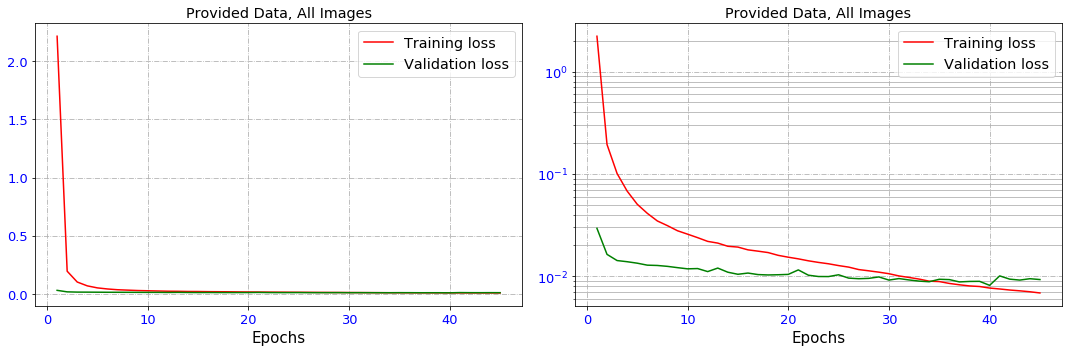

In [45]:
model_name = "001-model-conv-6-fc-4-all-data-01"
model_filename = "saved-models/" + model_name + ".h5"
history_filename = "saved-models/" + model_name + ".p"

checkpoint_file = model_filename

with open(history_filename, "rb") as file_pi:
    model_history = pickle.load(file_pi)

plot_title = "Provided Data, All Images"
plot_file_name="images/" + model_name + "-a.jpg"

Sdc.plot_model_history(loss, validation_loss, plot_title, plot_file_name)

In [ ]:
from importlib import reload

import selfDrivingCarModules
reload(selfDrivingCarModules)
from selfDrivingCarModules import Sdc

import dataProcessingModules
reload(dataProcessingModules)
from dataProcessingModules import DataGenerator4Regression

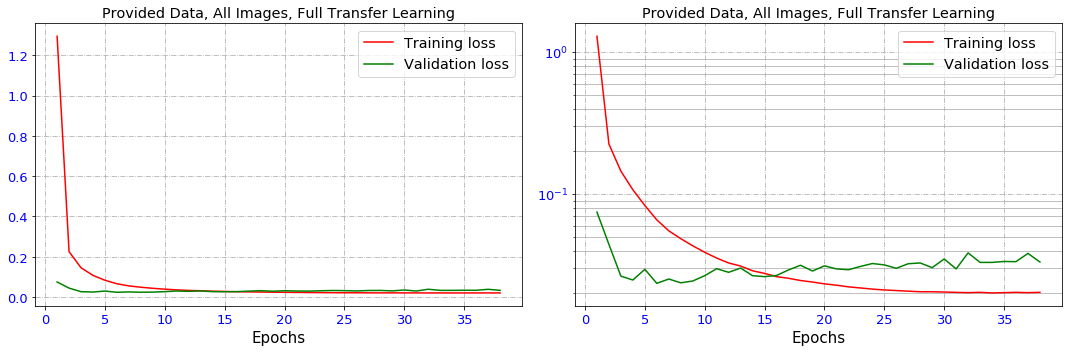

In [48]:
model_name = "020-model-inception-full-all-data-01"
model_filename = "saved-models/" + model_name + ".h5"
history_filename = "saved-models/" + model_name + ".p"

checkpoint_file = model_filename

# with open(history_filename, "rb") as file_pi:
#    model_history = pickle.load(file_pi)

model_loss = [1.2943, 0.2251, 0.1450, 0.1072, 0.0831, 0.0658, 0.0551, 0.0485, 0.0432, 0.0389, 0.0354, 0.0327, 0.0311, 0.0288, 
              0.0276, 0.0262, 0.0255, 0.0246, 0.0240, 0.0233, 0.0228, 0.0222, 0.0218, 0.0214, 0.0211, 0.0209, 0.0207, 0.0205, 
              0.0205, 0.0204, 0.0203, 0.0202, 0.0203, 0.0201, 0.0202, 0.0203, 0.0202, 0.0203]

model_val_loss = [0.0746, 0.0442, 0.0264, 0.0248, 0.0295, 0.0235, 0.0252, 0.0237, 0.0244, 0.0266, 0.0298, 0.0281, 0.0301, 0.0266, 
                  0.0262, 0.0267, 0.0292, 0.0315, 0.0287, 0.0312, 0.0297, 0.0293, 0.0309, 0.0324, 0.0317, 0.0300, 0.0323, 0.0327, 
                  0.0303, 0.0349, 0.0297, 0.0385, 0.0330, 0.0330, 0.0335, 0.0334, 0.0382, 0.0332]

plot_title = "Provided Data, All Images, Full Transfer Learning"
plot_file_name="images/" + model_name + "-a.jpg"

Sdc.plot_model_history(model_loss, model_val_loss, plot_title, plot_file_name)

In [2]:
# Load pickled data
import pickle

import pandas as pd
import cv2
import numpy as np
from sklearn import preprocessing
import os
from random import shuffle
import glob
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import matplotlib.image as mpimg
import csv

from keras.layers import Input, InputLayer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, Lambda, Cropping2D
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import keras
from keras import backend as K
from keras.preprocessing import image


Using TensorFlow backend.


In [3]:
from importlib import reload

import selfDrivingCarModules
reload(selfDrivingCarModules)
from selfDrivingCarModules import Sdc

import dataProcessingModules
reload(dataProcessingModules)
from dataProcessingModules import DataGenerator4Regression


In [4]:
data_path = "data/"
csv_file = data_path + "driving_log.csv"

x_partitions = {"train": None, "validation": None}
# y_partitions = {"train": None, "validation": None}

# x_partitions["train"], x_partitions["validation"], y_partitions["train"], y_partitions["validation"] = \
#     Sdc.generate_partition_ids(data_path, csv_file, validation_split=0.2, limit=64, image_series_type=Sdc.__CENTER_IMAGES__)

x_partitions["train"], x_partitions["validation"], y_values = \
    Sdc.generate_partition_ids(data_path, csv_file, validation_split=0.2, limit=0, image_series_type=Sdc.__ALL_IMAGES__, 
                              correction_factor=0.1)


In [5]:
"""
# Parameters
params = {"dim": (32,32,3), 
          "batch_size": 64, 
          "model_type": "regression", 
          "n_classes": 6, 
          "n_channels": 1, 
          "shuffle": True}
"""

batch_size = 64

image_sizes = (160, 320)

params = {"dims": (*image_sizes, 3), 
          "batch_size": batch_size, 
          "n_channels": 1,
          "augment_data": True,
          "rescale_zero_mean": True,
          "shuffle": True}

training_generator = DataGenerator4Regression(x_partitions["train"], y_values, **params)
validation_generator = DataGenerator4Regression(x_partitions["validation"], y_values, **params)

In [6]:
# print(training_generator[1][0].shape[0])
# print(validation_generator[1][0].shape[0])

x_data = training_generator[0][0]
y_data = training_generator[0][1]

test_index = 10

print(len(training_generator))
print(y_data[test_index], y_data[test_index + batch_size])
print(np.min(x_data[test_index]), np.max(x_data[test_index]))


301
0.1 -0.1
-1.0 1.0


### Without Transfer Learning - Training a New Network from Scratch  

In [8]:
# define SGD optimizer
# momentum = 0.5
# sgd = SGD(lr=0.01, momentum=momentum, decay=0.0, nesterov=False)

# compile the model
# model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

model.compile(loss="mse", optimizer="adam")
# history = model.fit(x_trains, y_trains, validation_split=0.2, epochs=5, shuffle=True, callbacks=None, verbose=1)

history = model.fit_generator(generator=training_generator, validation_data=validation_generator, 
                              use_multiprocessing=True, workers=2, epochs=20)

# model.fit(x_trains, y_trains, validation_split=0.2, shuffle=True, epochs=5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
301/301 [==============================] - 1140s 4s/step - loss: 0.3038 - val_loss: 0.0229
Epoch 2/20
301/301 [==============================] - 1111s 4s/step - loss: 0.0426 - val_loss: 0.0171
Epoch 3/20
301/301 [==============================] - 1136s 4s/step - loss: 0.0274 - val_loss: 0.0161
Epoch 4/20
301/301 [==============================] - 1095s 4s/step - loss: 0.0225 - val_loss: 0.0151
Epoch 5/20
301/301 [==============================] - 1146s 4s/step - loss: 0.0198 - val_loss: 0.0141
Epoch 6/20
301/301 [==============================] - 1167s 4s/step - loss: 0.0176 - val_loss: 0.0130
Epoch 7/20
301/301 [==============================] - 1121s 4s/step - loss: 0.0159 - val_loss: 0.0125
Epoch 8/20
301/301 [==============================] - 1151s 4s/step - loss: 0.0145 - val_loss: 0.0120
Epoch 9/20
301/301 [==============================] - 1125s 4s/step - loss: 0.0138 - val_loss: 0.0116
Epoch 10/20
301/301 [=============

In [9]:
model.save("saved-models/011-model-conv-6-fc-3-all-aug-crop.h5")

In [10]:
history.history["val_loss"]

[0.022908362510303655,
 0.017146214557190734,
 0.016054343146582443,
 0.015139938828845819,
 0.014146461660663287,
 0.013013311885297299,
 0.012487601817895969,
 0.0119560061643521,
 0.011642055983344713,
 0.011350177147736153,
 0.011011775806546211,
 0.011151735987514257,
 0.010850069466978312,
 0.010883754628400008,
 0.010604190112402042,
 0.010431073078264793,
 0.010377075939128797,
 0.010168081851055225,
 0.010359637457877397,
 0.010064438730478287]

In [11]:
history.history["loss"]

[0.30376339440181405,
 0.0425700679718458,
 0.0274016271496928,
 0.022473791515163804,
 0.01976407230816212,
 0.01755530356067508,
 0.015923776670028006,
 0.014519235272381293,
 0.013847876053947052,
 0.013294449506135677,
 0.012749145434012147,
 0.01248390523351704,
 0.012106656633701139,
 0.011763825681543232,
 0.011487378831643401,
 0.011126751615433797,
 0.010956986109568332,
 0.01062105816055671,
 0.01040237160721342,
 0.010236822676680907]

One can fairly quickly utilize a pre-trained model with [Keras Applications](https://keras.io/applications/). 

### Transfer Learning, Available Models   

1. **AlexNet**, developed in 2012, was the first breakthrough NN. AlexNet is one of the most understood and one of the best network architectures that one likes to start with. 

- **VGGNet or VGG (using 224x224 images as input):**, developed by Virtual Geometry Group at Oxford university in 2014, contains simple and elegant architcture which makes it great for transfer learning. The VGG architecture is just a long sequence of 3x3 convolutions, broken up by 2x2 pooling layers, and then followed up by two or three FC layers at the end. The flexibility of VGG is one of its biggest strengths. There are actually two versions of VGG, VGG16 and VGG19 (where the numbers denote the number of layers included in each respective model). Both of them are supported by Keras. 

```python
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet', include_top=False)
```

- **GoogLeNet/Inception in Keras (using 229x229 images as input):**, developed in 2013 by Google, performed even slightly better than the VGG, 6.7% vs 7.3% error. GoogLeNet's great advantage is that it really runs very fast. The Google team developed a model called Inception module which trains really well and it is efficiently deployable. The Inception module creates a situation that in which the total number of parameters is very small. This is why GoogLeNet almost runs as fast as AlexNet. Therefore, GoogLeNet is a great choice to investigate if we need to run our network in realtime. 

```python
from keras.applications.inception_v3 import InceptionV3
model = InceptionV3(weights='imagenet', include_top=False)
```

- **ResNet (using 224x224 images as input):**, developed by Microsoft in 2015, has a massive 152 layers (AlexNet has 8 layers, VGG has 19 layers, and GoogLeNet has 22 layers). ResNet structure is similar to VGG's. ResNet achives a loss of only 3% on imagenet, which is actually better than normal human accuracy. 


**Transfeer Learning Tips:**

The approach for using transfer learning will be different. There are four main cases: 

1. new data set is small, new data is similar to original training data
- new data set is small, new data is different from original training data
- new data set is large, new data is similar to original training data
- new data set is large, new data is different from original training data  


### Small new data set and similar to the original training data: 

- slice off the end of the neural network
- add a new fully connected layer that matches the number of classes in the new data set
- randomize the weights of the new fully connected layer; freeze all the weights from the pre-trained network
- train the network to update the weights of the new fully connected layer  

To avoid overfitting on the small data set, the weights of the original network will be held constant rather than re-training the weights.


## Transfer learning using provided data 

### InceptionV3: Pre-trained with frozen weights 
To start, we use an ImageNet pre-trained model with all weights frozen in the InceptionV3 model. We will also drop the end layer and append new layers onto it. 

### Adding new layers

Unlike the Keras's `Sequential` model that I used above for pure training model, I rather use the [Model API](https://keras.io/models/model/) this time. This model is useful if one wants to use more advanced concepts like [skip layers](https://en.wikipedia.org/wiki/Residual_neural_network), for instance (which were used heavily in ResNet). 

The camera image sizes that I am going to use are `160x320` (height, width), so I need to re-size the images up to the `input_size` I specified earlier `139x139`. To do so, I try both fixed and variable aspect ratios. 

[GlobalAveragePooling2D, an alternative to overfitting](https://datascience.stackexchange.com/questions/28120/globalaveragepooling2d-in-inception-v3-example) 

In [7]:
# Load our images first, and we'll check what we have
# from keras.applications.vgg16 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

from keras.layers import Input, Lambda
import tensorflow as tf
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping


In [8]:
resized_input_shape = (139, 139)

freeze_flag = True # `True` to freeze layers, `False` for full training 
weights_flag = "imagenet" # 'imagenet' or None 
preprocess_flag = True # Should be true for ImageNet pre-trained typically 


# Using smaller than the default 299x299x3 input for InceptionV3
# which will speed up training. Keras v2.0.9 supports down to 139x139x3

# input_size = 139

# Using Inception with ImageNet pre-trained weights
inception = InceptionV3(weights=weights_flag, include_top=False, input_shape=(*resized_input_shape, 3))

if (freeze_flag == True):
    for layer in inception.layers:
        layer.trainable = False

# inception.summary()


Instructions for updating:
Colocations handled automatically by placer.


In [9]:
# Makes the input placeholder layer with image shape
input_ph = Input(shape=(*image_sizes, 3))

preprocessed_input = Cropping2D(cropping=((50,20), (0,0)), input_shape=(*image_sizes, 3))(input_ph)
preprocessed_input = Lambda(lambda image: tf.image.resize_images( \
    image, (139, 139), method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False))(preprocessed_input)

# preprocessed_input = Lambda(lambda x: x / 255.0 - 0.5, input_shape=(*input_size, 3))(preprocessed_input)

inception_output = inception(preprocessed_input)

# layer_output = Flatten()(inception_output)
layer_output = GlobalAveragePooling2D()(inception_output)

layer_output = Dense(128, activation=None, name="fc0")(layer_output)
layer_output = Dropout(rate=0.20)(layer_output)

layer_output = Dense(64, activation=None, name="fc1")(layer_output)
layer_output = Dropout(rate=0.20)(layer_output)

layer_output = Dense(32, activation=None, name="fc2")(layer_output)
layer_output = Dropout(rate=0.20)(layer_output)

predictions = Dense(1, activation=None, name="fc3")(layer_output)


# layer_output = GlobalAveragePooling2D()(inception_output)
# layer_output = Dense(64, activation="relu")(layer_output)
# predictions = Dense(1, activation="relu")(layer_output)

# predictions = Dense(1, activation="softmax")(layer_output)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
model = Model(inputs=input_ph, outputs=predictions)
model.compile(optimizer="Adam", loss="mse", metrics=["mse"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 139, 139, 3)       0         
_________________________________________________________________
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
fc0 (Dense)                  (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

In [11]:
checkpoint_path = "saved-models/020-model-inception-fc-1-all-aug-crop.h5"

checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor="val_loss", save_best_only=True)
# stopper = EarlyStopping(monitor="val_loss", min_delta=1e-5, patience=5)

In [ ]:
history = model.fit_generator(generator=training_generator, validation_data=validation_generator, 
                              use_multiprocessing=True, workers=2, epochs=50, callbacks=[checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
301/301 [==============================] - 2134s 7s/step - loss: 1.2943 - mean_squared_error: 1.2943 - val_loss: 0.0746 - val_mean_squared_error: 0.0746
Epoch 2/50
301/301 [==============================] - 2106s 7s/step - loss: 0.2251 - mean_squared_error: 0.2251 - val_loss: 0.0442 - val_mean_squared_error: 0.0442
Epoch 3/50
301/301 [==============================] - 2097s 7s/step - loss: 0.1450 - mean_squared_error: 0.1450 - val_loss: 0.0264 - val_mean_squared_error: 0.0264
Epoch 4/50
301/301 [==============================] - 2093s 7s/step - loss: 0.1072 - mean_squared_error: 0.1072 - val_loss: 0.0248 - val_mean_squared_error: 0.0248
Epoch 5/50
301/301 [==============================] - 2108s 7s/step - loss: 0.0831 - mean_squared_error: 0.0831 - val_loss: 0.0295 - val_mean_squared_error: 0.0295
Epoch 6/50
301/301 [==============================] - 2087s 7s/step - loss: 0.0658 - mean_squared_error: 0.0658 - val_loss: 0.0235 -

In [15]:
model.save("saved-models/020-model-inception-fc-3-all-aug-crop.h5")

In [14]:
history.history["val_loss"]

[3.488986981709798,
 1.2009359129269919,
 0.36151622017224627,
 0.49821309924125673,
 0.1856471147139867,
 0.09700092360377312,
 0.13303978751103082,
 0.07989827901124955,
 0.04268636390566826,
 0.05469229777654012,
 0.043955231308937075,
 0.030053540120522183,
 0.030743354683121046,
 0.02757382904489835,
 0.033058609316746396,
 0.025153869688510896,
 0.024542662625511486,
 0.02407898833354314,
 0.02331083359817664,
 0.02308579295873642]

In [15]:
history.history["loss"]

[15.96035653491353,
 1.1904215323568579,
 1.3343286842998872,
 1.5260523316076031,
 1.4353188339657958,
 1.4061426306483753,
 1.165782324301444,
 0.9261236992785304,
 0.6829963413583876,
 0.4698280945073727,
 0.3493711829086475,
 0.2945328994446815,
 0.20977260437221623,
 0.17026889284583818,
 0.13305591479983442,
 0.10573032886978004,
 0.08869736344612318,
 0.06537080442291558,
 0.054036763456473715,
 0.04655024927864439]

In [ ]:
image_paths = glob("images/*.jpg")

i = 2 # Can change this to your desired image to test
img_path = image_paths[i]

img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [2]:
# Set a couple flags for training - you can ignore these for now
freeze_flag = True  # `True` to freeze layers, `False` for full training
weights_flag = "imagenet" # 'imagenet' or None
preprocess_flag = True # Should be true for ImageNet pre-trained typically

# Loads in InceptionV3
from keras.applications.inception_v3 import InceptionV3

# We can use smaller than the default 299x299x3 input for InceptionV3
# which will speed up training. Keras v2.0.9 supports down to 139x139x3
input_size = 139

# Using Inception with ImageNet pre-trained weights
inception = InceptionV3(weights=weights_flag, include_top=False,
                        input_shape=(input_size,input_size,3))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 29s 0us/step


We'll use Inception V3 for this lab, although you can use the same techniques with any of the models in [Keras Applications](https://keras.io/applications/). Do note that certain models are only available in certain versions of Keras; this workspace uses Keras v2.0.9, for which you can see the available models [here](https://faroit.github.io/keras-docs/2.0.9/applications/).

In the above, we've set Inception to use an `input_shape` of 139x139x3 instead of the default 299x299x3. This will help us to speed up our training a bit later (and we'll actually be upsampling from smaller images, so we aren't losing data here). In order to do so, we also must set `include_top` to `False`, which means the final fully-connected layer with 1,000 nodes for each ImageNet class is dropped, as well as a Global Average Pooling layer.

### Pre-trained with frozen weights
To start, we'll see how an ImageNet pre-trained model with all weights frozen in the InceptionV3 model performs. We will also drop the end layer and append new layers onto it, although you could do this in different ways (not drop the end and add new layers, drop more layers than we will here, etc.).

You can freeze layers by setting `layer.trainable` to False for a given `layer`. Within a `model`, you can get the list of layers with `model.layers`.

In [3]:
if freeze_flag == True:
    ## TODO: Iterate through the layers of the Inception model
    ##       loaded above and set all of them to have trainable = False
    for layer in inception.layers:
        layer.trainable = False

### Dropping layers
You can drop layers from a model with `model.layers.pop()`. Before you do this, you should check out what the actual layers of the model are with Keras's `.summary()` function.

In [4]:
## TODO: Use the model summary function to see all layers in the
##       loaded Inception model
inception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 139, 139, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 69, 69, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 69, 69, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 69, 69, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In a normal Inception network, you would see from the model summary that the last two layers were a global average pooling layer, and a fully-connected "Dense" layer. However, since we set `include_top` to `False`, both of these get dropped. If you otherwise wanted to drop additional layers, you would use:

```
inception.layers.pop()
```

Note that `pop()` works from the end of the model backwards.

It's important to note two things here:
1. How many layers you drop is up to you, typically. We dropped the final two already by setting `include_top` to False in the original loading of the model, but you could instead just run `pop()` twice to achieve similar results. (*Note:* Keras requires us to set `include_top` to False in order to change the `input_shape`.) Additional layers could be dropped by additional calls to `pop()`.
2. If you make a mistake with `pop()`, you'll want to reload the model. If you use it multiple times, the model will continue to drop more and more layers, so you may need to check `model.summary()` again to check your work.

### Adding new layers

Now, you can start to add your own layers. While we've used Keras's `Sequential` model before for simplicity, we'll actually use the [Model API](https://keras.io/models/model/) this time. This functions a little differently, in that instead of using `model.add()`, you explicitly tell the model which previous layer to attach to the current layer. This is useful if you want to use more advanced concepts like [skip layers](https://en.wikipedia.org/wiki/Residual_neural_network), for instance (which were used heavily in ResNet).

For example, if you had a previous layer named `inp`:
```
x = Dropout(0.2)(inp)
```
is how you would attach a new dropout layer `x`, with it's input coming from a layer with the variable name `inp`.

We are going to use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), which consists of 60,000 32x32 images of 10 classes. We need to use Keras's `Input` function to do so, and then we want to re-size the images up to the `input_size` we specified earlier (139x139).

In [5]:
from keras.layers import Input, Lambda
import tensorflow as tf

# Makes the input placeholder layer 32x32x3 for CIFAR-10
cifar_input = Input(shape=(32,32,3))

# Re-sizes the input with Kera's Lambda layer & attach to cifar_input
resized_input = Lambda(lambda image: tf.image.resize_images( 
    image, (input_size, input_size)))(cifar_input)

# Feeds the re-sized input into Inception model
# You will need to update the model name if you changed it earlier!
inp = inception(resized_input)

In [6]:
# Imports fully-connected "Dense" layers & Global Average Pooling
from keras.layers import Dense, GlobalAveragePooling2D

## TODO: Setting `include_top` to False earlier also removed the
##       GlobalAveragePooling2D layer, but we still want it.
##       Add it here, and make sure to connect it to the end of Inception
x = GlobalAveragePooling2D()(inp)

## TODO: Create two new fully-connected layers using the Model API
##       format discussed above. The first layer should use `out`
##       as its input, along with ReLU activation. You can choose
##       how many nodes it has, although 512 or less is a good idea.
##       The second layer should take this first layer as input, and
##       be named "predictions", with Softmax activation and 
##       10 nodes, as we'll be using the CIFAR10 dataset.
x = Dense(512, activation = 'relu')(x)
predictions = Dense(10, activation = 'softmax')(x)

We're almost done with our new model! Now we just need to use the actual Model API to create the full model.

In [7]:
# Imports the Model API
from keras.models import Model

# Creates the model, assuming your final layer is named "predictions"
model = Model(inputs=cifar_input, outputs=predictions)

# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Check the summary of this new model to confirm the architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 139, 139, 3)       0         
_________________________________________________________________
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 22,857,002
Trainable params: 1,054,218
Non-trainable params: 21,802,784
________________________________________________________

Great job creating a new model architecture from Inception! Notice how this method of adding layers before InceptionV3 and appending to the end of it made InceptionV3 condense down into one line in the summary; if you use the Inception model's normal input (which you could gather from `inception.layers.input`), it would instead show all the layers like before.

Most of the rest of the code in the notebook just goes toward loading our data, pre-processing it, and starting our training in Keras, although there's one other good point to make here - Keras callbacks.

### Keras Callbacks
Keras [callbacks](https://keras.io/callbacks/) allow you to gather and store additional information during training, such as the best model, or even stop training early if the validation accuracy has stopped improving. These methods can help to avoid overfitting, or avoid other issues.

There's two key callbacks to mention here, `ModelCheckpoint` and `EarlyStopping`. As the names may suggest, model checkpoint saves down the best model so far based on a given metric, while early stopping will end training before the specified number of epochs if the chosen metric no longer improves after a given amount of time.

To set these callbacks, you could do the following:
```
checkpoint = ModelCheckpoint(filepath=save_path, monitor='val_loss', save_best_only=True)
```
This would save a model to a specified `save_path`, based on validation loss, and only save down the best models. If you set `save_best_only` to `False`, every single epoch will save down another version of the model.
```
stopper = EarlyStopping(monitor='val_acc', min_delta=0.0003, patience=5)
```
This will monitor validation accuracy, and if it has not decreased by more than 0.0003 from the previous best validation accuracy for 5 epochs, training will end early.


You still need to actually feed these callbacks into `fit()` when you train the model (along with all other relevant data to feed into `fit`):
```
model.fit(callbacks=[checkpoint, stopper])
```

## GPU time

The rest of the notebook will give you the code for training, so you can turn on the GPU at this point - but first, **make sure to save your jupyter notebook**. Once the GPU is turned on, it will load whatever your last notebook checkpoint is. 

While we suggest reading through the code below to make sure you understand it, you can otherwise go ahead and select *Cell > Run All* (or *Kernel > Restart & Run All* if already using GPU) to run through all cells in the notebook.

In [8]:
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from keras.datasets import cifar10

(X_train, y_train), (X_val, y_val) = cifar10.load_data()

# One-hot encode the labels
label_binarizer = LabelBinarizer()
y_one_hot_train = label_binarizer.fit_transform(y_train)
y_one_hot_val = label_binarizer.fit_transform(y_val)

# Shuffle the training & test data
X_train, y_one_hot_train = shuffle(X_train, y_one_hot_train)
X_val, y_one_hot_val = shuffle(X_val, y_one_hot_val)

# We are only going to use the first 10,000 images for speed reasons
# And only the first 2,000 images from the test set
X_train = X_train[:10000]
y_one_hot_train = y_one_hot_train[:10000]
X_val = X_val[:2000]
y_one_hot_val = y_one_hot_val[:2000]

170500096/170498071 [==============================] - 9s 0us/step


You can check out Keras's [ImageDataGenerator documentation](https://faroit.github.io/keras-docs/2.0.9/preprocessing/image/) for more information on the below - you can also add additional image augmentation through this function, although we are skipping that step here so you can potentially explore it in the upcoming project.

In [9]:
# Use a generator to pre-process our images for ImageNet
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

if preprocess_flag == True:
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
else:
    datagen = ImageDataGenerator()
    val_datagen = ImageDataGenerator()

In [10]:
# Train the model
batch_size = 32
epochs = 5
# Note: we aren't using callbacks here since we only are using 5 epochs to conserve GPU time
model.fit_generator(datagen.flow(X_train, y_one_hot_train, batch_size=batch_size), 
                    steps_per_epoch=len(X_train)/batch_size, epochs=epochs, verbose=1, 
                    validation_data=val_datagen.flow(X_val, y_one_hot_val, batch_size=batch_size),
                    validation_steps=len(X_val)/batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
313/312 [==============================] - 554s 2s/step - loss: 1.2907 - acc: 0.5694 - val_loss: 1.6065 - val_acc: 0.6680
Epoch 2/5
313/312 [==============================] - 559s 2s/step - loss: 0.9867 - acc: 0.6616 - val_loss: 1.4338 - val_acc: 0.6960
Epoch 3/5
313/312 [==============================] - 581s 2s/step - loss: 0.8792 - acc: 0.6967 - val_loss: 1.3231 - val_acc: 0.7190
Epoch 4/5
313/312 [==============================] - 531s 2s/step - loss: 0.8161 - acc: 0.7192 - val_loss: 1.7038 - val_acc: 0.6770
Epoch 5/5
313/312 [==============================] - 529s 2s/step - loss: 0.7953 - acc: 0.7246 - val_loss: 1.4295 - val_acc: 0.7000


As you may have noticed, CIFAR-10 is a fairly tough dataset. However, given that we are only training on a small subset of the data, only training for five epochs, and not using any image augmentation, the results are still fairly impressive!

We achieved ~70% validation accuracy here, although your results may vary.

## [Optional] Test without frozen weights, or by training from scratch.

Since the majority of the model was frozen above, training speed is pretty quick. You may also want to check out the training speed, as well as final accuracy, if you don't freeze the weights. Note that this can be fairly slow, so we're marking this as optional in order to conserve GPU time. 

If you do want to see the results from doing so, go back to the first code cell and set `freeze_flag` to `False`. If you want to completely train from scratch without ImageNet pre-trained weights, follow the previous step as well as setting `weights_flag` to `None`. Then, go to *Kernel > Restart & Run All*.

## Comparison

So that you don't use up your GPU time, we've tried out these results ourselves as well.

Training Mode | Val Acc @ 1 epoch | Val Acc @ 5 epoch | Time per epoch
---- | :----: | :----: | ----:
Frozen weights | 65.5% | 70.3% | 50 seconds
Unfrozen weights | 50.6% | 71.6% | 142 seconds
No pre-trained weights | 19.2% | 39.2% | 142 seconds

From the above, we can see that the pre-trained model with frozen weights actually began converging the fastest (already at 65.5% after 1 epoch), while the model re-training from the pre-trained weights slightly edged it out after 5 epochs.

However, this does not tell the whole story - the training accuracy was substantially higher, nearing 87% for the unfrozen weights model. It actually began overfit the data much more under this method. We would likely be able to counteract some of this issue by using data augmentation. On the flip side, the model using frozen weights could also have been improved by actually only freezing a portion of the weights; some of these are likely more specific to ImageNet classes as it gets later in the network, as opposed to the simpler features extracted early in the network.

### The Power of Transfer Learning
Comparing the last line to the other two really shows the power of transfer learning. After five epochs, a model without ImageNet pre-training had only achieved 39.2% accuracy, compared to over 70% for the other two. As such, pre-training the network has saved substantial time, especially given the additional training time needed when the weights are not frozen.

There is also evidence found in various research that pre-training on ImageNet weights will result in a higher overall accuracy than completely training from scratch, even when using a substantially different dataset.